In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import seaborn as sns
import pandas
import scipy
import pdb
control_variables = ['Dimension', 'Temporal', 'Dark', 'Smell', 'Auditory', 'Whisker Trimming']

In [63]:
def xform_coords_euclidean(r,theta,phi):
    x=r*np.sin(theta)*np.cos(phi)
    y=r*np.sin(theta)*np.sin(phi)
    z=r*np.cos(phi)
    return x,y,z


def inverse_xform_coords(r,theta_y,theta_z):
    xgimbal_xoffset=168
    ygimbal_to_joint=64
    ygimbal_yoffset=100
    zgimbal_to_joint=47
    zgimbal_zoffset=117
    x_origin=1024
    y_origin=608
    z_origin=531
    Ax = np.sqrt(
        xgimbal_xoffset**2 + r**2 - 2*xgimbal_xoffset*r*np.cos(theta_y)*np.cos(theta_z)
        )
    gammay = -np.arcsin(
        np.sin(theta_y)*
        np.sqrt(
            (r*np.cos(theta_y)*np.cos(theta_z))**2 + 
            (r*np.sin(theta_y)*np.cos(theta_z))**2
            )/
        np.sqrt(
            (xgimbal_xoffset - r*np.cos(theta_y)*np.cos(theta_z))**2 +
            (r*np.sin(theta_y)*np.cos(theta_z))**2
            )
        )
    gammaz = -np.arcsin(r*np.sin(theta_z)/Ax)
    Ay = np.sqrt(
        (ygimbal_to_joint - ygimbal_to_joint*np.cos(gammay)*np.cos(gammaz))**2 + 
        (ygimbal_yoffset - ygimbal_to_joint*np.sin(gammay)*np.cos(gammaz))**2 + 
        (ygimbal_to_joint*np.sin(gammaz))**2
        )
    Az = np.sqrt(
        (zgimbal_to_joint - zgimbal_to_joint*np.cos(gammay)*np.cos(gammaz))**2 + 
        (zgimbal_to_joint*np.sin(gammay)*np.cos(gammaz))**2 + 
        (zgimbal_zoffset - zgimbal_to_joint*np.sin(gammaz))**2
        )
    Ax = np.round((Ax - xgimbal_xoffset)/50*1024 + x_origin, decimals = 1) #bits
    Ay = np.round((Ay - ygimbal_yoffset)/50*1024 + y_origin, decimals = 1) #bits
    Az = np.round((Az - zgimbal_zoffset)/50*1024 + z_origin, decimals = 1) #bits
    #convert tranformed commands to appropriate data types/format
    
    return Ax,Ay,Az


def forward_xform_coords(x,y,z):
    Axx=168
    Ly=64
    Ayy=100
    Lz=47
    Azz=117
    X0=1024
    Y0=608
    Z0=531
    Ax_est = (x - X0)/1024*50 + Axx
    Ay_est = (y - Y0)/1024*50 + Ayy
    Az_est = (z - Z0)/1024*50 + Azz
    c1 = np.asarray((0,0,0))
    c2 = np.asarray((Ly,Ayy,0))
    c3 = np.asarray((Lz,0,Azz))
    u = np.asarray((Ly,Ayy,0))/np.sqrt(Ly**2+Ayy**2)
    v = c3-np.dot(c3,u)*u
    v = v/np.sqrt(np.dot(v,v))
    w = np.cross(u,v)
    y = np.asarray((0,1,0))
    z = np.asarray((0,0,1))
    U2 = np.sqrt(np.sum((c2-c1)**2))
    U3 = np.dot(c3,u)
    V3 = np.dot(c3,v)
    r3 = np.sqrt(Az_est**2+(Ly-Lz)**2-2*Az_est*(Ly-Lz)*np.cos(np.pi-np.arccos((Az_est**2+Lz**2-np.dot(c3,c3))
                                                                                  /(2*Az_est*Lz))))
    Pu = (Ly**2-Ay_est**2+U2**2)/(2*U2)
    Pv = (U3**2+V3**2-2*U3*Pu+Ly**2-r3**2)/(2*V3)
    Pw = np.sqrt(-Pu**2-Pv**2+Ly**2)
    Py = Pu*np.dot(u,y) + Pv*np.dot(v,y) + Pw*np.dot(w,y)
    Pz = Pu*np.dot(u,z) + Pv*np.dot(v,z) + Pw*np.dot(w,z)
    gammay_est = np.arcsin(Py/(Ly*np.cos(np.arcsin(Pz/Ly))))
    gammaz_est = np.arcsin(Pz/Ly)
    r = np.sqrt(Axx**2+Ax_est**2-(2*Axx*Ax_est*np.cos(gammay_est)*np.cos(gammaz_est)))
    dz=np.sin(-gammaz_est)
    dy=np.sin(-gammay_est)
    theta = np.arcsin(dz*Ax_est/r)
    phi = np.arcsin(Ax_est*dy*np.cos(-gammaz_est)/r/np.cos(theta))
    x = r*np.cos(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.cos(phi)
    z = r*np.sin(phi)
    
    
    
    return r,theta,phi,x,y,z


def euclidean_to_spherical(x,y,z):
    r=np.sqrt(x**2+y**2+z**2)
    phi=np.arccos(z/r)
    theta=np.arcsin(y/(r*np.sin(phi)))
    return r,theta,phi




In [64]:
x,y,z=xform_coords_euclidean(40,0.00740480489693061,0.00740480489693061)#-0.740480489693061
x,y,z


# REW WIN ZONE COORDINATES 
# xyz high/low 
# high, 1000, 658/558, 581/350

(0.29618136895965924, 0.0021932053367116696, 39.99890338229952)

In [65]:
rz,tz,pz,xz,yz,zz=forward_xform_coords(800,558,350)
xz,yz,zz

(13.95802696204065, -25.826452339729514, -16.51344326196932)

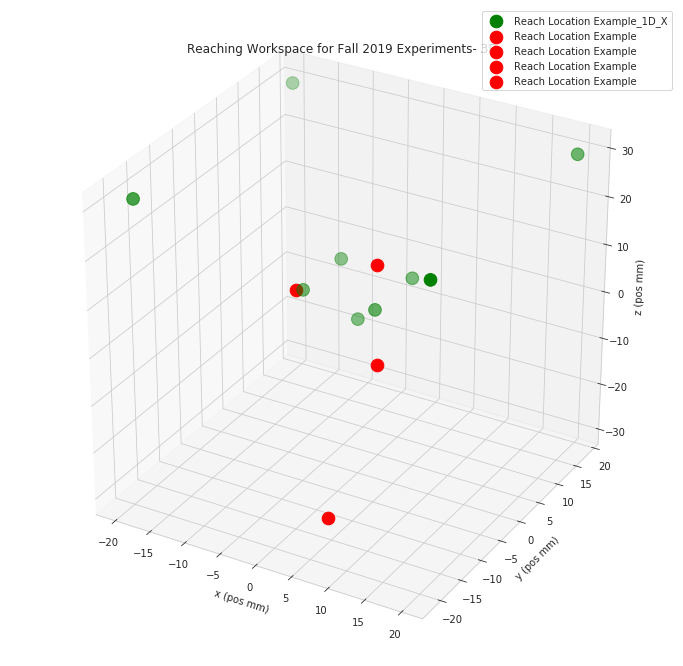

In [66]:
R = [10,10,10,10,40,40,40,40,0]
theta =[0.740480489693061,0.740480489693061,-0.740480489693061,-0.740480489693061,
     0.740480489693061,0.740480489693061,-0.740480489693061,-0.740480489693061,0]
phi=[0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,
   0.740480489693061,-0.740480489693061,0]

tdx,tdy,tdz = xform_coords_euclidean(R,theta,phi)
oned_plot(tdx,tdy,tdz)

In [52]:
rr,tt,pp=euclidean_to_spherical(0,0,20)
rr,tt,pp
# outer bounds (19.919350364951445, 18.20570876435603, 29.525779404204705)

x_array = np.asarray([20,15,10,5,0,-5,-10,-15,-20])
y_array = np.asarray([8,6,4,2,0,-2,-4,-6,-8])
z_array = np.asarray([8,6,4,2,0,-2,-4,-6,-8])
zero_array=np.asarray([0,0,0,0,0,0,0,0,0])
tzero_array=np.asarray([20,20,20,20,20,20,20,20,20]).reshape((9,1))





/home/kallanved/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars


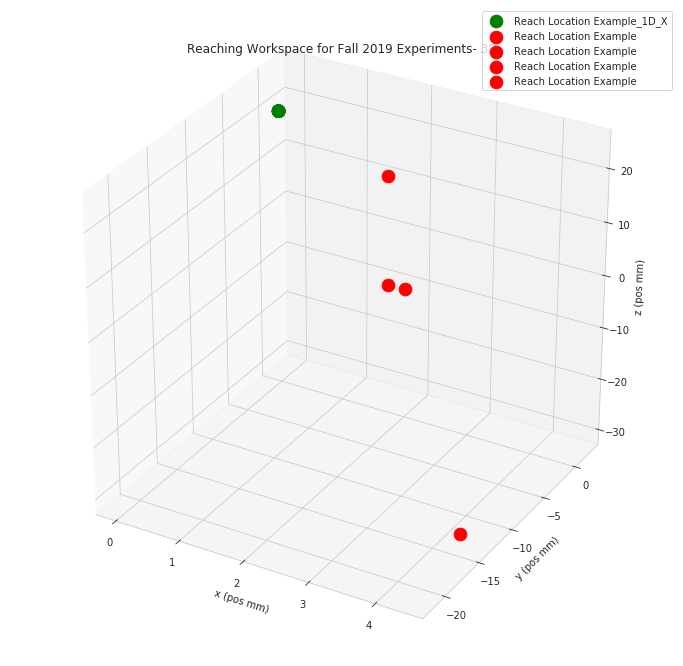

In [61]:
def oned_plot(X,Y,Z):
    sns.set_style("whitegrid", {'axes.grid' : False})
    elev=180
    azim=-90
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1, projection='3d',label='Reaching Volume Projection')
    ax.scatter(X,Y,Z,marker='o',color='g',s=160,label='Reach Location Example_1D_X')
    ax.scatter(4.21683040484592, -21.494587859661944, 23.338366290807603,marker='o',color='r',s=160,label='Reach Location Example')
    ax.scatter(1.5110430700786808, 2.0334802828896854, 10.436257439411955,marker='o',color='r',s=160,label='Reach Location Example')
    ax.scatter(1.5217442442195874, 1.9610389746027241, -10.619226792425742,marker='o',color='r',s=160,label='Reach Location Example')
    ax.scatter(4.380208304189223, -14.635340768638795, -29.085973544319657,marker='o',color='r',s=160,label='Reach Location Example')
    ax.set_xlabel('x (pos mm)')
    ax.set_ylabel('y (pos mm)')
    ax.set_zlabel('z (pos mm)')
    plt.legend()
    plt.title('Reaching Workspace for Fall 2019 Experiments- 3D')
    #plt.savefig('Reaching_3dCone.png')
    plt.show()
    
oned_plot(zero_array,zero_array,tzero_array)

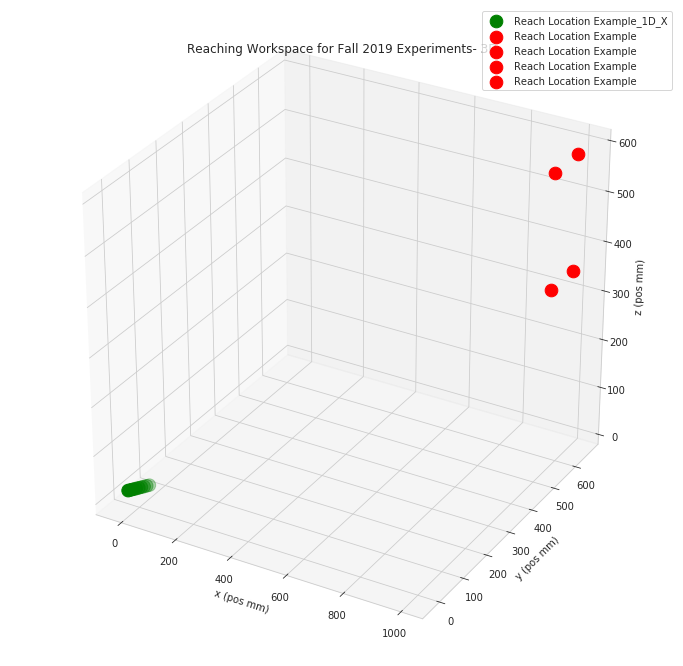

In [44]:
def twod_plot(X,Y,Z):
    sns.set_style("whitegrid", {'axes.grid' : False})
    elev=180
    azim=-90
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1, projection='3d',label='Reaching Volume Projection')
    
    #pdb.set_trace()
    ax.scatter(X,Y,Z,marker='o',color='g',s=160,label='Reach Location Example_1D_X')
    ax.scatter(1000,658,350,marker='o',color='r',s=160,label='Reach Location Example')
    ax.scatter(1000,658,581,marker='o',color='r',s=160,label='Reach Location Example')
    ax.scatter(1000,558,581,marker='o',color='r',s=160,label='Reach Location Example')
    ax.scatter(1000,558,350,marker='o',color='r',s=160,label='Reach Location Example')
    ax.set_xlabel('x (pos mm)')
    ax.set_ylabel('y (pos mm)')
    ax.set_zlabel('z (pos mm)')
    plt.legend()
    plt.title('Reaching Workspace for Fall 2019 Experiments- 3D')
    #plt.savefig('Reaching_3dCone.png')
    plt.show()
twod_plot(x_array,x_array,tzero_array)

# Positions
## 0-D : (0,0,0) -> is 20,0,0 in command coordinates, so we need to normalize these coordinates and use these to anchor our task coordinate system.
## 1-D : 

# Control Variables 
## Vision, smell,  auditory, tactile feedback (whisking)

### Vision: Switch lights on/off
### Smell: IP injection of methamizole [Brittbo et al 1995, specific dose from Yamasoba 2007] 300mg/kg
### Auditory: Tone pip/ other sound
### Whisker Trimming : Must anesthetize, trim

## For Fall experiments, do controls of 3 sessions.


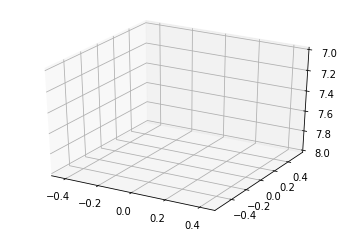

In [2]:
# reaching locations from previous experiments 
R = [10,10,10,10,40,40,40,40,20,20, 20, 20]
theta =[0.740480489693061,0.740480489693061,-0.740480489693061,-0.740480489693061,
     0.740480489693061,0.740480489693061,-0.740480489693061,-0.740480489693061,0.740480489693061,0.740480489693061
       ,-0.740480489693061,-0.740480489693061]
phi=[0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,
   0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061]
def plot_experiment_surface(theta,phi):
    elev=90
    azim=0
    THETA, PHI = np.meshgrid(theta, phi)
    R = np.abs(np.cos(PHI**2))
    X = R * np.sin(PHI) * np.cos(THETA)
    Y = R * np.sin(PHI) * np.sin(THETA)
    Z = R * np.cos(PHI)
    xdata = scipy.ndimage.zoom(X, 10)
    ydata = scipy.ndimage.zoom(Y, 10)
    zdata = scipy.ndimage.zoom(Z, 10)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    plot = ax.plot_surface(
        xdata, ydata, zdata, rstride=1, cstride=1)
    ax.set_zlim(8,7)
    #ax.view_init(elev,azim)
    plt.show()
    


plot_experiment_surface(theta,phi)

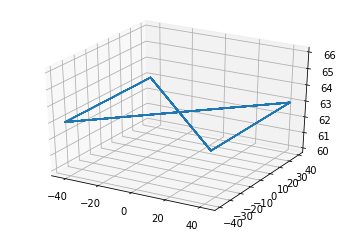

In [3]:
def plot_experiment_lines(theta,phi):
    elev=0
    azim=0
    THETA, PHI = np.meshgrid(theta, phi)
    R = np.abs(np.cos(PHI**2))*100
    X = R * np.sin(PHI) * np.cos(THETA)
    Y = R * np.sin(PHI) * np.sin(THETA)
    Z = R * np.cos(PHI)
    xdata = scipy.ndimage.zoom(X, 2)
    ydata = scipy.ndimage.zoom(Y, 2)
    zdata = scipy.ndimage.zoom(Z, 2)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.plot_wireframe(X,Y,Z,rstride=12, cstride=12)
    #ax.view_init(elev,azim)
    plt.show()
plot_experiment_lines(theta,phi)

In [4]:
def plot_experiment_contour(theta,phi):
    elev=180
    azim=-90
    THETA, PHI = np.meshgrid(theta, phi)
    R = np.abs(np.cos(PHI**2))
    X = np.asarray(R * np.sin(PHI) * np.cos(THETA))
    Y = np.asarray(R * np.sin(PHI) * np.sin(THETA))
    Z = np.asarray(R * np.cos(PHI))
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(X,Y,Z,
                cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.view_init(elev,azim)
    plt.show()
    
plot_experiment_contour(theta,phi)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (0,4) and requested shape (144,4)

<Figure size 432x288 with 1 Axes>

In [5]:
def generate_trial_data(r_array,theta_array,phi_array):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-5-bb6d9768e9a6>, line 2)

# Locations
## Handle locations are selected from an appropriate 3-D volume to represent the desired experimental outcome. From this volume we sample 0, 1, 2 and 3-D locations (where the dimension is the increase or decrease in dimension of the task eg does the task vary in 1, 2 or 3 dimensions inside euclidean space).

# Block Variables

### In order to examine different planes, we must select for 3 different planes (x-z, y-z, x-y).
### We need a similar amount of points between dimensions (eg between 1, 2 and 3-D we need to share both a single point in this space as well as have the same amount of space 
### We also would like to control for the temporal order of points presented to the rat. These changes are useful to sift out the effects of changing positions. Stratagies- random sample with replacement, center to outward in plane, can repeat positions!, sample in circle


In [48]:
#R = [10,10,10,10,40,40,40,40,20,20, 20, 20]
#theta =[0.740480489693061,0.740480489693061,-0.740480489693061,-0.740480489693061,
  #   0.740480489693061,0.740480489693061,-0.740480489693061,-0.740480489693061,0.740480489693061,0.740480489693061
  #     ,-0.740480489693061,-0.740480489693061]
#phi=[0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,
  # 0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061]
##### line for x ########
R1_x  = [10,15,20,25,30,35,40,0]
t1_x = [0,0,0,0,0,0,0,0]
p1_x = [0,0,0,0,0,0,0,0]
##### line for y ########
R1_x  = [10,15,20,25,30,35,0]
t1_x = [0,0,0,0,0,0,0]
p1_x = [0,0,0,0,0,0,0]
##### line for z #########
R1_x  = [10,15,20,25,30,35,40]
t1_x = [0,0,0,0,0,0,0]
p1_x = [0,0,0,0,0,0,0]

#### x-y plane #####
R1_x  = [10,15,20,25,30,35,40]
t1_x = [0,0,0,0,0,0,0]
p1_x = [0,0,0,0,0,0,0]

##### x-z plane #####
R1_x  = [10,15,20,25,30,35,40]
t1_x = [0,0,0,0,0,0,0]
p1_x = [0,0,0,0,0,0,0]
##### y-z plane #####
R1_x  = [10,15,20,25,30,35,40]
t1_x = [0,0,0,0,0,0,0]
p1_x = [0,0,0,0,0,0,0]
##### x-y-z plane #####
R1_x  = [10,15,20,25,30,35,40,0]
t1_x = [0,0,0,0,0,0,0,0]
p1_x = [0,0,0,0,0,0,0,0]




# Positions in Different Coordinate Frames: The Inverse and Forward Transform
### We must be able to transform from reaching coordinates (supplied as the command file during an experiment) to robot potentiometer values (what the robot is driven towards by the valves). This is accomplished with forward and inverse kinematic transforms. The explicit derivation is given by Brian Gereke here https://docs.google.com/document/d/1xOt152T8yYz8QwV9U_RnKHztCNRpr385yJVEVw_hFrs/edit
### Robot commands are given in spherical, reaching coordinates. We can transform these into x,y,z through simple Euclidean geometry. We can then transform these coordinates into potentiometer values OR just plot them in reaching space.

In [46]:
def xform_coords_euclidean(r,theta,phi):
    x=r*np.sin(theta)*np.cos(phi)
    y=r*np.sin(theta)*np.sin(phi)
    z=r*np.cos(phi)
    return x,y,z


def inverse_xform_coords(r,theta_y,theta_z):
    xgimbal_xoffset=168
    ygimbal_to_joint=64
    ygimbal_yoffset=100
    zgimbal_to_joint=47
    zgimbal_zoffset=117
    x_origin=1024
    y_origin=608
    z_origin=531
    Ax = np.sqrt(
        xgimbal_xoffset**2 + r**2 - 2*xgimbal_xoffset*r*np.cos(theta_y)*np.cos(theta_z)
        )
    gammay = -np.arcsin(
        np.sin(theta_y)*
        np.sqrt(
            (r*np.cos(theta_y)*np.cos(theta_z))**2 + 
            (r*np.sin(theta_y)*np.cos(theta_z))**2
            )/
        np.sqrt(
            (xgimbal_xoffset - r*np.cos(theta_y)*np.cos(theta_z))**2 +
            (r*np.sin(theta_y)*np.cos(theta_z))**2
            )
        )
    gammaz = -np.arcsin(r*np.sin(theta_z)/Ax)
    Ay = np.sqrt(
        (ygimbal_to_joint - ygimbal_to_joint*np.cos(gammay)*np.cos(gammaz))**2 + 
        (ygimbal_yoffset - ygimbal_to_joint*np.sin(gammay)*np.cos(gammaz))**2 + 
        (ygimbal_to_joint*np.sin(gammaz))**2
        )
    Az = np.sqrt(
        (zgimbal_to_joint - zgimbal_to_joint*np.cos(gammay)*np.cos(gammaz))**2 + 
        (zgimbal_to_joint*np.sin(gammay)*np.cos(gammaz))**2 + 
        (zgimbal_zoffset - zgimbal_to_joint*np.sin(gammaz))**2
        )
    Ax = np.round((Ax - xgimbal_xoffset)/50*1024 + x_origin, decimals = 1) #bits
    Ay = np.round((Ay - ygimbal_yoffset)/50*1024 + y_origin, decimals = 1) #bits
    Az = np.round((Az - zgimbal_zoffset)/50*1024 + z_origin, decimals = 1) #bits
    #convert tranformed commands to appropriate data types/format
    
    return Ax,Ay,Az


def forward_xform_coords(x,y,z):
    Axx=168
    Ly=64
    Ayy=100
    Lz=47
    Azz=117
    X0=1024
    Y0=608
    Z0=531
    Ax_est = (x - X0)/1024*50 + Axx
    Ay_est = (y - Y0)/1024*50 + Ayy
    Az_est = (z - Z0)/1024*50 + Azz
    c1 = np.asarray((0,0,0))
    c2 = np.asarray((Ly,Ayy,0))
    c3 = np.asarray((Lz,0,Azz))
    u = np.asarray((Ly,Ayy,0))/np.sqrt(Ly**2+Ayy**2)
    v = c3-np.dot(c3,u)*u
    v = v/np.sqrt(np.dot(v,v))
    w = np.cross(u,v)
    y = np.asarray((0,1,0))
    z = np.asarray((0,0,1))
    U2 = np.sqrt(np.sum((c2-c1)**2))
    U3 = np.dot(c3,u)
    V3 = np.dot(c3,v)
    r3 = np.sqrt(Az_est**2+(Ly-Lz)**2-2*Az_est*(Ly-Lz)*np.cos(np.pi-np.arccos((Az_est**2+Lz**2-np.dot(c3,c3))
                                                                                  /(2*Az_est*Lz))))
    Pu = (Ly**2-Ay_est**2+U2**2)/(2*U2)
    Pv = (U3**2+V3**2-2*U3*Pu+Ly**2-r3**2)/(2*V3)
    Pw = np.sqrt(-Pu**2-Pv**2+Ly**2)
    Py = Pu*np.dot(u,y) + Pv*np.dot(v,y) + Pw*np.dot(w,y)
    Pz = Pu*np.dot(u,z) + Pv*np.dot(v,z) + Pw*np.dot(w,z)
    gammay_est = np.arcsin(Py/(Ly*np.cos(np.arcsin(Pz/Ly))))
    gammaz_est = np.arcsin(Pz/Ly)
    r = np.sqrt(Axx**2+Ax_est**2-(2*Axx*Ax_est*np.cos(gammay_est)*np.cos(gammaz_est)))
    dz=np.sin(-gammaz_est)
    dy=np.sin(-gammay_est)
    theta = np.arcsin(dz*Ax_est/r)
    phi = np.arcsin(Ax_est*dy*np.cos(-gammaz_est)/r/np.cos(theta))
    x = r*np.cos(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.cos(phi)
    z = r*np.sin(phi)
    
    
    
    return r,theta,phi,x,y,z


In [56]:
x,y,z = inverse_xform_coords(np.asarray(R),np.asarray(theta),np.asarray(phi))

for i,v in enumerate(R):
    r,theta,phi,x,y,z = forward_xform_coords(r[i],theta[i],phi[i]) # 10,+.74,.74
    

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [55]:
x,y,z

(5.486008458569933, 5.031604872468066, 6.61964113421993)

In [54]:
R = [10,10,10,10,40,40,40,40,0]
theta =[0.740480489693061,0.740480489693061,-0.740480489693061,-0.740480489693061,
     0.740480489693061,0.740480489693061,-0.740480489693061,-0.740480489693061,0]
phi=[0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,0.740480489693061,-0.740480489693061,
   0.740480489693061,-0.740480489693061,0]
x,y,z = inverse_xform_coords(np.asarray(R),np.asarray(theta),np.asarray(phi))
xx1,yx1,zx1 = inverse_xform_coords(np.asarray(R1_x),np.asarray(t1_x),np.asarray(p1_x))
xx1

NameError: name 'R1_x' is not defined

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pdb
sns.set_style("whitegrid", {'axes.grid' : False})

def plot_experiment_contour(X,Y,Z):
    elev=180
    azim=-90
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1, projection='3d',label='Reaching Volume Projection')
    
    #pdb.set_trace()
    #ax.plot(X,Y,np.squeeze(Z))
    ax.plot_wireframe(X,Y,Z,rstride=1, cstride=1)
    ax.scatter(1000,610,530,marker='o',color='r',s=460,label='Rat Area')
    ax.scatter(X[-1],Y[-1],Z[-1],marker='o',color='m',s=460,label='0 Position')
    ax.scatter(X,Y,Z,marker='o',color='g',s=160,label='Reach Location Example')
    ax.set_xlabel('x (pos mm)')
    ax.set_ylabel('y (pos mm)')
    ax.set_zlabel('z (pos mm)')
    plt.legend()
    plt.title('Reaching Workspace for Fall 2019 Experiments- 3D')
    #plt.savefig('Reaching_3dCone.png')
    plt.show()
    
plot_experiment_contour(x,y,z.reshape(z.shape[0],1))

In [ ]:
plot_experiment_contour(xx1,yx1,zx1.reshape(zx1.shape[0],1))

In [ ]:
def plot_m_experiment_contour(X,Y,Z):
    sns.set_style("whitegrid", {'axes.grid' : False})
    elev=180
    azim=-90
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1, projection='3d',label='Reaching Volume Projection')
    
    #pdb.set_trace()
    #ax.plot(X,Y,np.squeeze(Z))
    ax.plot_wireframe(X,Y,Z,rstride=1, cstride=1,color='g')
    ax.scatter(X,Y,Z,marker='o',color='g',s=160,label='Reach Location Example_1D_X')
    #ax.plot_wireframe(Y,X,Z,rstride=1, cstride=1,color='y')
    ax.scatter(Y,X,Z,marker='o',color='y',s=160,label='Reach Location Example_1D_Y')
    #ax.plot_wireframe(Z,Y,X,rstride=1, cstride=1,color='b')
    ax.scatter(Z,Y,X,marker='o',color='b',s=160,label='Reach Location Example_1D_Z')
    
    ax.scatter(X[-1],Y[-1],Z[-1],marker='o',color='m',s=460,label='0 Position')
    ax.set_xlabel('x (pos mm)')
    ax.set_ylabel('y (pos mm)')
    ax.set_zlabel('z (pos mm)')
    plt.legend()
    plt.title('Reaching Workspace for Fall 2019 Experiments- 3D')
    #plt.savefig('Reaching_3dCone.png')
    plt.show()
plot_m_experiment_contour(xx1,yx1,zx1.reshape(zx1.shape[0],1))

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

fig = plt.figure()
ax = p3.Axes3D(fig)
sns.set_style("whitegrid", {'axes.grid' : False})

# create the first plot
point, = ax.plot([xx1[0]], [yx1[0]], [zx1[0]], 'o')
line, = ax.plot(zx1,zx1 ,zx1 , label='Command Locations in X Dimension 1-D')
ax.legend()
#ax.set_xlim([-1.5, 1.5])
#ax.set_ylim([-1.5, 1.5])
#ax.set_zlim([-1.5, 1.5])

# second option - move the point position at every frame
def update_point(n, x, y, z, point):
    point.set_data(np.array([x[n], y[n]]))
    point.set_3d_properties(z[n], 'z')
    return point

ani=animation.FuncAnimation(fig, update_point, 1, fargs=(xx1, yx1, zx1, point),interval=2, blit=True)

plt.show()